# Percolational regions as a polycentricity measure

In [20]:
import json
import os
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.cluster import DBSCAN

In [21]:
os.chdir('D:/bachelors/datasets/')

# Preparation

In [22]:
with open('Variables/mappers/communes_names_map.json') as infile:
    names_map = json.load(infile)

In [23]:
nodes_path = 'analysis/yearly_graphs_v2/total/nodes_total_{}.csv'
datatables_path = 'translated_data_v2/data_{}.csv'

In [24]:
def read_raw_data(datatable_path):
    df_current = pd.read_csv(datatable_path)
    df_current['geo_departure'], df_current['geo_arrival'] = df_current['geo_departure'].map(names_map), df_current['geo_arrival'].map(names_map)
    df_current.dropna(subset = ['geo_departure', 'geo_arrival'], inplace = True)
#     df_current = df_current[df_current.geo_departure != df_current.geo_arrival]
    df_current = pd.pivot_table(df_current, 'uid_person', 'geo_departure', 'geo_arrival', aggfunc = 'nunique')
    df_current.values[[np.arange(df_current.shape[0])]*2] = 0
    maxim = np.max(df_current.fillna(0).values)
    df_current = ((df_current / maxim) * -1 + 1).fillna(1)
    
    return df_current

## Create a list of epsilon values to cluster

In [159]:
epses = [float(i[:4]) for i in np.arange(0.1, 1.01, 0.01).astype(str).tolist()] 

In [25]:
epses = [i/100 for i in range(1, 101)]

## Plot tools

In [26]:
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
import matplotlib

medium_font = fm.FontProperties(fname =  "D:/bachelors/datasets/viz/Roboto-Medium.ttf", size = 12)
regluar_font = fm.FontProperties(fname = "D:/bachelors/datasets/viz/Roboto-Regular.ttf", size = 12)

colors = {
    'peach' : '#FCB886',
    'blue' : '#6FC7F7',
    'green' : '#78AF34',
    'red' : '#D25B5B',
    'grey' : '#8B8B8B'
}

In [27]:
def model_regions(dat):
    """Builds hierarchy of regions for a distance matrix"""
    series_list = []
    for eps in epses:
        labs = DBSCAN(eps = eps, min_samples = 2, metric = 'precomputed').fit(dat).labels_
        series_list.append(pd.Series(labs, dat.index).rename(f'percolation_{eps}'))
    percolation_classes = pd.DataFrame(series_list).transpose()
    percolation_classes = percolation_classes.applymap(lambda elem: None if elem == -1 else elem)
    return percolation_classes

In [28]:
def map_series(series):
    if series.name in dict_perc_reg.keys():
        return series.map(dict_perc_reg[series.name])
    else:
        return series

In [29]:
with open('Variables/mappers/communes_names_toRussian_map.json') as infile:
    rus_names = json.load(infile)

In [30]:
import seaborn as sns

In [31]:
def plot_percolation(matrix, year):
    plt.figure(figsize = (11,11))

    ax = sns.heatmap(matrix,
                     linewidths = .3,
                     zorder = 1,
                     cmap = 'viridis',
                     cbar = False)
    plt.grid(ls = ':', zorder = 0)
    plt.xticks(fontproperties = regluar_font)

    plt.yticks(fontproperties = regluar_font)
    ax.set_title(f'{year}', loc = 'left', fontproperties = medium_font, fontsize=24)
    ax.set_xlabel('Фильтр интенсивности поездок', fontproperties = medium_font, fontsize=18)
    ax.set_ylabel('Главный муниципалитет кластера', fontproperties = medium_font, fontsize=18)
    plt.tight_layout()
    plt.savefig(f'analysis/percolation_regions/plots_v3/{year}_percolation.png')
    plt.close('all')

In [32]:
import math

def round_down(n, decimals=0):
    multiplier = 10 ** decimals
    return math.floor(n * multiplier) / multiplier

In [33]:
bounds = gpd.read_file('../qgis/base/Netherlands_communes.gpkg')

In [34]:
from collections import defaultdict

In [35]:
year

2017

In [37]:
sustain = []
regions_cores_list = []
region_to_core_map = defaultdict(dict)
for year in range(2004,2018):
    dat = read_raw_data(datatables_path.format(year))
    nodes = pd.read_csv(nodes_path.format(year))
    
    percolation_classes = model_regions(dat)
    percolation_classes = percolation_classes.reset_index().merge(nodes[['commune', 'flow_cent']], left_on = 'geo_departure', right_on = 'commune', how = 'left').drop(columns = ['geo_departure'])
    dict_perc_reg = {
        f'percolation_{eps}' : percolation_classes.set_index(
            'commune'
        ).groupby(
            f'percolation_{eps}'
        )['flow_cent'].idxmax().to_dict() for eps in epses
    }
    percolation_classes = percolation_classes.apply(map_series).apply(
        lambda x: x.map(rus_names) if x.name not in ['commune', 'flow_cent'] else x
    )

    matrix = percolation_classes.drop(columns = ['flow_cent', 'commune']).apply(lambda column: column.value_counts())
    percolation_classes = percolation_classes.set_index('commune')
    
    matrix.columns = [float(i.split('_')[1]) for i in matrix.columns]
    matrix = matrix.sort_values(by = list(matrix.columns))
    first_value = matrix.dropna(axis=1, how = 'all').columns[0]
    matrix = matrix.loc[:, round_down(first_value, 1):]
#     break
    matrix = matrix.assign(
        order = matrix.apply(lambda row: row.loc[row == row.dropna().iloc[0]].index[0], axis = 'columns'),
        parent = matrix.apply(
            lambda row: round(row.loc[row == row.dropna().iloc[-1]].index[0] + .01, 2) if \
            row.loc[row == row.dropna().iloc[-1]].index[0] < 1 else 1,
            axis = 'columns'),
        duration = matrix.apply(lambda x: x.isnull().sum(), axis='columns')
    )







#     matrix['order'] = matrix.apply(lambda row: row.loc[row == row.dropna().iloc[0]].index[0], axis = 'columns')
#     matrix['duration'] = matrix.apply(lambda x: x.isnull().sum(), axis='columns')
#     matrix['parent'] = matrix.apply(lambda row: row.loc[row == row.dropna().iloc[-1]].index[0] + .01, axis = 'columns')
    matrix = matrix.sort_values(by = ['order', 'duration'])
    plot_percolation(matrix.drop(columns = ['order', 'duration', 'parent']), year)
    
    cutpoint_core = matrix['order'].to_dict()
    parent_core = matrix['parent'].to_dict()
    matrix.drop(columns = ['order', 'parent', 'duration'], inplace = True)
    sustain.append(len(matrix.columns) - matrix.isna().sum(axis = 'columns').mean())
    regions_cores = {}
    for name, cpt in cutpoint_core.items():
        regions_cores.update(
            percolation_classes[percolation_classes[f'percolation_{cpt}'] == name][f'percolation_{cpt}'].to_dict()
        )
        
    parent_cores = {}
    for name, cpt in parent_core.items():
        parent_cores.update(
            percolation_classes[percolation_classes[f'percolation_{cpt}'] == name][f'percolation_{cpt}'].to_dict()
        )
#     break
    region_to_core_map[str(year)] = regions_cores    
    regions_cores_list.append(bounds.assign(core = lambda frame: frame.NAME.map(regions_cores), 
                                            year = year))

C:\Users\mtopn\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys
C:\Users\mtopn\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys
C:\Users\mtopn\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will res

In [44]:
matrix.drop(columns = ['order', 'parent', 'duration'], inplace = True)

In [45]:
sutsain = len(matrix.columns) - matrix.isna().sum(axis = 'columns').mean()

In [53]:
sutsain

7.371428571428567

<BarContainer object of 14 artists>

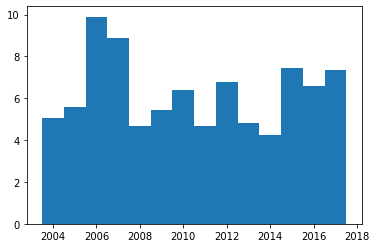

In [58]:
plt.bar([i for i in range(2004, 2018)], sustain, width=1)
# plt.yticks([i for i in range(len(sustain))], [i for i in range(2004, 2018)])

In [51]:
df = pd.DataFrame([pd.Series(regions_cores).rename('core'),  pd.Series(parent_cores).rename('parent')]).transpose().dropna().reset_index().drop(columns= ['index']).drop_duplicates()

In [63]:
df[df.core != df.parent]

,core,parent
3,Роттердам,Амстердам
9,Мидделбург,Гус
12,Гронинген,Амстердам
22,Херлен,Амстердам
28,Нейменген,Амстердам
31,Смаллигерланд,Леуварден
32,Смаллигерланд,Амстердам
45,Маастрихт,Амстердам
47,Энсхеде,Амстердам
56,Арнем,Амстердам


In [57]:
pd.DataFrame([pd.Series(regions_cores).rename('core'),  pd.Series(parent_cores).rename('parent')]).transpose().dropna().reset_index().drop(columns = [0])

KeyError: '[0] not found in axis'

In [50]:
pd.DataFrame([parent_cores, regions_cores])

,'s-Hertogenbosch,Aa en Hunze,Aalburg,Aalsmeer,Aalten,Achtkarspelen,Alblasserdam,Albrandswaard,Alkmaar,Almelo,...,Zevenaar,Zoetermeer,Zoeterwoude,Zuidhorn,Zuidplas,Zundert,Zutphen,Zwartewaterland,Zwijndrecht,Zwolle
0,Амстердам,Ассен,Амстердам,Амстердам,Амстердам,Амстердам,Амстердам,Амстердам,Алкмар,Амстердам,...,Амстердам,Амстердам,Амстердам,Амстердам,Амстердам,Амстердам,Амстердам,Амстердам,Амстердам,Амстердам
1,Хертогенбос,Ассен,Веркендам,NaN,NaN,NaN,NaN,NaN,Алкмар,Алмело,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Зволле


In [ ]:
bounds.assign(core = lambda frame: frame.NAME.map(regions_cores),
              parent = )

In [47]:
matrix['parent'].unique().tolist()

[1.0,
 0.81,
 0.6900000000000001,
 0.75,
 0.9400000000000001,
 0.91,
 0.84,
 0.96,
 0.93,
 0.87,
 0.88,
 0.89,
 0.95,
 0.9,
 0.92,
 0.97,
 0.98]

In [49]:
parent_cores

{"'s-Hertogenbosch": 'Амстердам',
 'Aa en Hunze': 'Ассен',
 'Aalburg': 'Амстердам',
 'Aalsmeer': 'Амстердам',
 'Aalten': 'Амстердам',
 'Achtkarspelen': 'Амстердам',
 'Alblasserdam': 'Амстердам',
 'Albrandswaard': 'Амстердам',
 'Alkmaar': 'Алкмар',
 'Almelo': 'Амстердам',
 'Almere': 'Амстердам',
 'Alphen aan den Rijn': 'Амстердам',
 'Alphen-Chaam': 'Амстердам',
 'Ameland': 'Амстердам',
 'Amersfoort': 'Амстердам',
 'Amstelveen': 'Амстердам',
 'Amsterdam': 'Амстердам',
 'Apeldoorn': 'Амстердам',
 'Appingedam': 'Амстердам',
 'Arnhem': 'Амстердам',
 'Assen': 'Ассен',
 'Asten': 'Амстердам',
 'Baarle-Nassau': 'Амстердам',
 'Baarn': 'Амстердам',
 'Barendrecht': 'Амстердам',
 'Barneveld': 'Эдам-Волендам',
 'Bedum': 'Амстердам',
 'Beek': 'Амстердам',
 'Beemster': 'Амстердам',
 'Beesel': 'Амстердам',
 'Berg en Dal': 'Амстердам',
 'Bergeijk': 'Амстердам',
 'Bergen op Zoom': 'Амстердам',
 'BergenL': 'Амстердам',
 'BergenNH': 'Алкмар',
 'Berkelland': 'Амстердам',
 'Bernheze': 'Амстердам',
 'Best': '

In [25]:
matrix.iloc[1]

0.60     NaN
0.61     NaN
0.62     NaN
0.63     NaN
0.64     NaN
0.65     4.0
0.66     4.0
0.67     4.0
0.68     4.0
0.69     4.0
0.70     5.0
0.71     6.0
0.72     6.0
0.73     6.0
0.74     6.0
0.75     6.0
0.76     6.0
0.77     7.0
0.78     7.0
0.79     9.0
0.80    10.0
0.81     NaN
0.82     NaN
0.83     NaN
0.84     NaN
0.85     NaN
0.86     NaN
0.87     NaN
0.88     NaN
0.89     NaN
0.90     NaN
0.91     NaN
0.92     NaN
0.93     NaN
0.94     NaN
0.95     NaN
0.96     NaN
0.97     NaN
0.98     NaN
0.99     NaN
1.00     NaN
Name: Роттердам, dtype: float64

In [29]:
matrix.iloc[1][matrix.iloc[1] == matrix.iloc[1].dropna().iloc[-1]].index[0]+.01

0.81

In [17]:
matrix

,0.6,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69,...,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1.0
Амстердам,NaN,3.0,3.0,3.0,3.0,4.0,4.0,4.0,4.0,4.0,...,55.0,69.0,74.0,152.0,233.0,297.0,346.0,368.0,376.0,380.0
Роттердам,NaN,NaN,NaN,NaN,NaN,4.0,4.0,4.0,4.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Утрехт,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Мидделбург,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Гронинген,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15.0,29.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Херенвен,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ассен,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Леуварден,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Херлен,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.0,13.0,17.0,22.0,24.0,NaN,NaN,NaN,NaN,NaN
Смаллигерланд,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [360]:
percolation_classes[percolation_classes[f'percolation_{cpt}'] == name][f'percolation_{cpt}']

commune
Geldermalsen    Гелдермалсен
Leerdam         Гелдермалсен
Lingewaal       Гелдермалсен
Name: percolation_0.96, dtype: object

In [362]:
region_to_core_map['2004']

{'Almere': 'Амстердам',
 'Amstelveen': 'Амстердам',
 'Amsterdam': 'Амстердам',
 'Capelle aan den IJssel': 'Роттердам',
 'Den Haag': 'Роттердам',
 'Leidschendam-Voorburg': 'Роттердам',
 'Rotterdam': 'Роттердам',
 'Nieuwegein': 'Утрехт',
 'Utrecht': 'Утрехт',
 'Middelburg': 'Мидделбург',
 'Veere': 'Мидделбург',
 'Vlissingen': 'Мидделбург',
 'Groningen': 'Гронинген',
 'Midden-Groningen': 'Гронинген',
 'Tynaarlo': 'Гронинген',
 'De Friese Meren': 'Леуварден',
 'Heerenveen': 'Леуварден',
 'Sudwest-Fryslan': 'Леуварден',
 'Leeuwarden': 'Леуварден',
 'Aa en Hunze': 'Ассен',
 'Assen': 'Ассен',
 'Midden-Drenthe': 'Ассен',
 'Heerlen': 'Херлен',
 'Kerkrade': 'Херлен',
 'Landgraaf': 'Херлен',
 'Borsele': 'Гус',
 'Goes': 'Гус',
 'Kapelle': 'Гус',
 'Berg en Dal': 'Нейменген',
 'Nijmegen': 'Нейменген',
 'Wijchen': 'Нейменген',
 'Opsterland': 'Смаллигерланд',
 'Smallingerland': 'Смаллигерланд',
 'Barneveld': 'Эдам-Волендам',
 'Ede': 'Эдам-Волендам',
 'Veenendaal': 'Эдам-Волендам',
 'Alkmaar': 'Алкмар'

In [377]:
all_reg = pd.concat(regions_cores_list)

In [371]:
regions_cores_list[0].dissolve(by = ['core']).to_file('analysis/percolation_regions/Reg-c-diss')

In [372]:
regions_cores_list[0].dissolve(by = ['core'])

,geometry,NAME,POPULATION,Area,DENSITY,year
core,,,,,,
Алкмар,"POLYGON ((4.7534284648213 52.59064240963311, 4...",BergenNH,29941,101038337,296.33,2004
Алмело,"POLYGON ((6.699747796244353 52.30806599809372,...",Almelo,72629,69314642,1047.82,2004
Амстердам,(POLYGON ((5.320289696606449 52.30273301632881...,Almere,203990,140261904,1454.35,2004
Апелдорн,"POLYGON ((6.083488112987778 52.14410987907019,...",Apeldoorn,161156,342208181,470.93,2004
Арнем,"POLYGON ((6.051964292400466 51.87137684668412,...",Arnhem,157223,101979154,1541.72,2004
Ассен,"POLYGON ((6.462139503573805 52.79949601823618,...",Aa en Hunze,25390,279914646,90.71,2004
Бреда,(POLYGON ((4.842593608877011 51.71502858021798...,Breda,183448,129322488,1418.53,2004
Венло,"POLYGON ((6.018171161832258 51.26738062812698,...",Peel en Maas,43312,161597362,268.02,2004
Веркендам,"POLYGON ((5.0846825189823 51.78068042019715, 5...",Aalburg,13153,53160520,247.42,2004


In [364]:
with open('analysis/percolation_regions/RegionCores.json', 'w') as outfile:
    json.dump(region_to_core_map, outfile)

In [365]:
all_reg[~all_reg.core.isna()]

,NAME,POPULATION,Area,DENSITY,geometry,core,year
0,Aa en Hunze,25390,279914646,90.71,(POLYGON ((6.944836772102481 52.99215596570361...,Ассен,2004
1,Assen,67708,83621452,809.70,(POLYGON ((6.568604595030538 52.94576501347922...,Ассен,2004
2,Borger-Odoorn,25351,272907572,92.89,(POLYGON ((7.020432471769706 52.87130845397606...,Эммен,2004
3,Coevorden,35299,299357668,117.92,(POLYGON ((6.815015728840681 52.64786459842855...,Эммен,2004
4,De Wolden,23917,226940619,105.39,(POLYGON ((6.454367764449058 52.78519798884386...,Меппел,2004
5,Emmen,107192,329803397,325.02,(POLYGON ((6.870277655592239 52.65226368421348...,Эммен,2004
6,Hoogeveen,55677,129637488,429.48,(POLYGON ((6.637271937646799 52.66955373033837...,Хогевен,2004
7,Meppel,33410,57499767,581.05,"(POLYGON ((6.27192353635592 52.66737147741451,...",Меппел,2004
8,Midden-Drenthe,33172,347422784,95.48,(POLYGON ((6.462139503573805 52.79949601823618...,Ассен,2004
10,Tynaarlo,33462,147712386,226.53,"(POLYGON ((6.5224298972442 53.19662712184467, ...",Гронинген,2004


In [374]:
all_reg = all_reg.dissolve(by = ['year', 'core']).reset_index()

In [379]:
all_reg.to_file('analysis/percolation_regions/RegionCores_diss.gpkg', driver = 'GPKG')

CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_RegionCores_diss_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_RegionCores_diss_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


In [324]:
cutpoint_core.items()

dict_items([('Амстердам', 0.06), ('Роттердам', 0.45), ('Гаага', 0.52), ('Нейменген', 0.73), ('Херлен', 0.77), ('Эйндховен', 0.79), ('Гронинген', 0.8), ('Апелдорн', 0.83), ('Дутинхем', 0.84), ('Эдам-Волендам', 0.84), ('Тилбург', 0.84), ('Зволле', 0.85), ('Ситтард-Гелен', 0.85), ('Маастрихт', 0.87), ('Энсхеде', 0.87), ('Мидделбург', 0.87), ('Алфен-ан-ден-Рейн', 0.88), ('Лиссе', 0.89), ('Эммен', 0.9), ('Росендал', 0.9), ('Гус', 0.91), ('Нордостполдер', 0.91), ('Венло', 0.91), ('Рурмонд', 0.91), ('Эйтхорн', 0.91), ('Бевервейк', 0.91), ('Делфзейл', 0.92), ('Смаллигерланд', 0.92), ('Верт', 0.93), ('Хардервейк', 0.93), ('Деурне', 0.94), ('Хюлст', 0.95), ('Зеволде', 0.96), ('Олдебрук', 0.96), ('Гелдермалсен', 0.96)])

In [308]:
cutpoint_core = matrix['order'].to_dict()

In [ ]:
cutpoint_core

In [313]:
cut = cutpoint_core['Амстердам']

In [312]:
f'percolation_{cutpoint_core['Амстердам']}'

SyntaxError: invalid syntax (<ipython-input-312-1bace7324c74>, line 1)

In [318]:
regions_cores = {}

In [319]:
regions_cores.update(percolation_classes.set_index('commune')[f'percolation_{cut}'].dropna().to_dict())

In [320]:
regions_cores

{'Amstelveen': 'Амстердам', 'Amsterdam': 'Амстердам', 'Zaanstad': 'Амстердам'}

In [143]:
bounds.merge(
    percolation_classes.reset_index(), left_on = 'NAME', right_on = 'commune', how = 'left'
).to_file('analysis/percolation_experiment.gpkg', driver = 'GPKG')

CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_percolation_experiment_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_percolation_experiment_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


In [130]:
import matplotlib.pyplot as plt

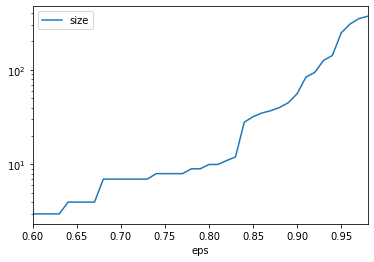

In [131]:
pd.DataFrame(table, columns = ['eps', 'size']).set_index('eps').plot()
plt.yscale('log')


In [132]:
df = pd.DataFrame(table, columns = ['eps', 'size']).set_index('eps').dropna()

In [134]:
import ruptures as rpt

In [140]:
df['size'].values

array([  3,   3,   3,   3,   4,   4,   4,   4,   7,   7,   7,   7,   7,
         7,   8,   8,   8,   8,   9,   9,  10,  10,  11,  12,  28,  32,
        35,  37,  40,  45,  56,  84,  94, 126, 142, 246, 305, 348, 369],
      dtype=int64)

In [152]:
algo = rpt.Pelt(model="l2").fit(np.log(df['size'].values))
result = algo.predict(pen=10)

In [153]:
result

[25, 39]

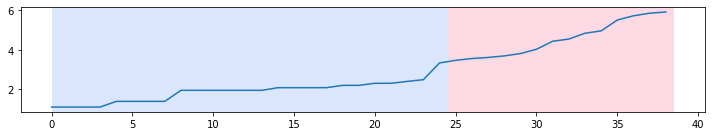

In [154]:
rpt.display(np.log(df['size'].values), result)
plt.show()

In [96]:
df['grad'] = np.gradient(df['size'])

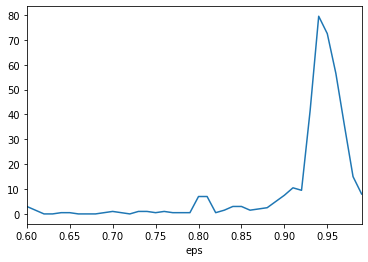

In [97]:
df['grad'].plot()

(array([4., 0., 5., 0., 0., 1., 0., 3., 0., 0., 2., 1., 2., 2., 0., 0., 0.,
        0., 0., 0., 0., 2., 1., 1., 1., 2., 2., 0., 1., 0., 1., 0., 1., 1.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 3.]),
 array([1.09861229, 1.19523183, 1.29185136, 1.3884709 , 1.48509044,
        1.58170997, 1.67832951, 1.77494905, 1.87156859, 1.96818812,
        2.06480766, 2.1614272 , 2.25804673, 2.35466627, 2.45128581,
        2.54790535, 2.64452488, 2.74114442, 2.83776396, 2.93438349,
        3.03100303, 3.12762257, 3.2242421 , 3.32086164, 3.41748118,
        3.51410072, 3.61072025, 3.70733979, 3.80395933, 3.90057886,
        3.9971984 , 4.09381794, 4.19043748, 4.28705701, 4.38367655,
        4.48029609, 4.57691562, 4.67353516, 4.7701547 , 4.86677424,
        4.96339377, 5.06001331, 5.15663285, 5.25325238, 5.34987192,
        5.44649146, 5.543111  , 5.63973053, 5.73635007, 5.83296961,
        5.92958914]),
 <a list of 50 Patch objects>)

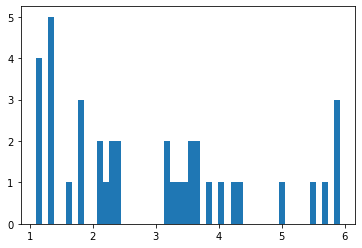

In [121]:
plt.hist(np.log(df['size']), bins = 50)

C:\Users\mtopn\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


eps
0.60        -inf
0.61    1.098612
0.62    1.098612
0.63    1.098612
0.64    1.098612
0.65    1.386294
0.66    1.386294
0.67    1.386294
0.68    1.386294
0.69    1.386294
0.70    1.609438
0.71    1.791759
0.72    1.791759
0.73    1.791759
0.74    2.079442
0.75    2.079442
0.76    2.197225
0.77    2.302585
0.78    2.302585
0.79    2.397895
0.80    2.397895
0.81    3.218876
0.82    3.218876
0.83    3.258097
0.84    3.332205
0.85    3.465736
0.86    3.526361
0.87    3.555348
0.88    3.637586
0.89    3.688879
0.90    3.871201
0.91    4.007333
0.92    4.234107
0.93    4.304065
0.94    5.023881
0.95    5.451038
0.96    5.693732
0.97    5.846439
0.98    5.908083
0.99    5.929589
Name: size, dtype: float64

ValueError: too many values to unpack (expected 2)

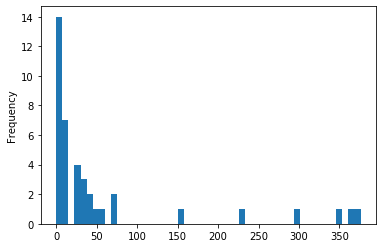

In [113]:
df['size'].plot.hist(bins = 50)
# plt.ylim('log')

In [98]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [99]:
dc = seasonal_decompose(df['size'].dropna(), model = 'additive', freq = 3)

In [100]:
DBSCAN(eps = 0.6, min_samples = 2, metric = 'precomputed').fit(dat).labels_

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

In [101]:
df['size'].index.astype(str).str[:4].astype(float).tolist()

[0.6,
 0.61,
 0.62,
 0.63,
 0.64,
 0.65,
 0.66,
 0.67,
 0.68,
 0.69,
 0.7,
 0.71,
 0.72,
 0.73,
 0.74,
 0.75,
 0.76,
 0.77,
 0.78,
 0.79,
 0.8,
 0.81,
 0.82,
 0.83,
 0.84,
 0.85,
 0.86,
 0.87,
 0.88,
 0.89,
 0.9,
 0.91,
 0.92,
 0.93,
 0.94,
 0.95,
 0.96,
 0.97,
 0.98,
 0.99]

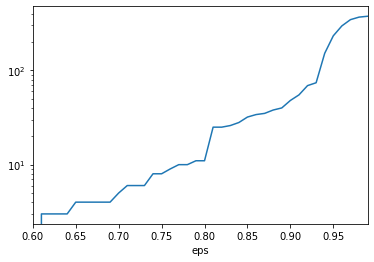

In [102]:
dc.observed.plot()

plt.yscale('log')

In [ ]:
dat

In [103]:
dc.observed

eps
0.60      0
0.61      3
0.62      3
0.63      3
0.64      3
0.65      4
0.66      4
0.67      4
0.68      4
0.69      4
0.70      5
0.71      6
0.72      6
0.73      6
0.74      8
0.75      8
0.76      9
0.77     10
0.78     10
0.79     11
0.80     11
0.81     25
0.82     25
0.83     26
0.84     28
0.85     32
0.86     34
0.87     35
0.88     38
0.89     40
0.90     48
0.91     55
0.92     69
0.93     74
0.94    152
0.95    233
0.96    297
0.97    346
0.98    368
0.99    376
Name: size, dtype: int64

In [62]:
dc.observed.loc[0.7400000000000001]

8.0

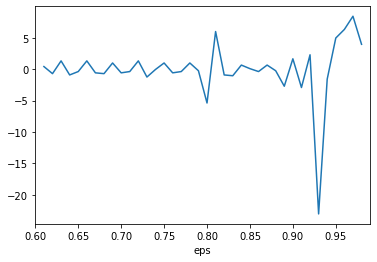

In [104]:
dc.resid.plot()

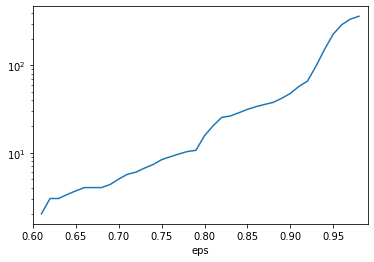

In [109]:
dc.trend.plot()
plt.yscale('log')

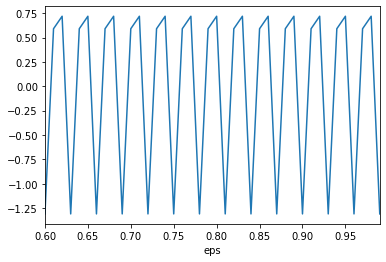

In [105]:
dc.seasonal.plot()

In [56]:
dc.seasonal.loc[dc.seasonal.index == 0.6900000000000001]

eps
0.69   -1.297009
Name: size, dtype: float64

In [48]:
dc.seasonal.index

Float64Index([              0.61,               0.62,               0.63,
                            0.64,               0.65,               0.66,
                            0.67,               0.68, 0.6900000000000001,
              0.7000000000000001, 0.7100000000000001, 0.7200000000000001,
              0.7300000000000001, 0.7400000000000001, 0.7500000000000001,
              0.7600000000000001, 0.7700000000000001, 0.7800000000000001,
              0.7900000000000001, 0.8000000000000002, 0.8100000000000002,
              0.8200000000000002, 0.8300000000000002, 0.8400000000000002,
              0.8500000000000002, 0.8600000000000002, 0.8700000000000002,
              0.8800000000000002, 0.8900000000000002, 0.9000000000000002,
              0.9100000000000003, 0.9200000000000003, 0.9300000000000003,
              0.9400000000000003, 0.9500000000000003, 0.9600000000000003,
              0.9700000000000003, 0.9800000000000003, 0.9900000000000003],
             dtype='float64', name='e

In [24]:
df['size'].d

eps
0.60      NaN
0.61      3.0
0.62      3.0
0.63      3.0
0.64      3.0
0.65      4.0
0.66      4.0
0.67      4.0
0.68      4.0
0.69      4.0
0.70      5.0
0.71      6.0
0.72      6.0
0.73      6.0
0.74      8.0
0.75      8.0
0.76      9.0
0.77     10.0
0.78     10.0
0.79     11.0
0.80     11.0
0.81     25.0
0.82     25.0
0.83     26.0
0.84     28.0
0.85     32.0
0.86     34.0
0.87     35.0
0.88     38.0
0.89     40.0
0.90     48.0
0.91     55.0
0.92     69.0
0.93     74.0
0.94    152.0
0.95    233.0
0.96    297.0
0.97    346.0
0.98    368.0
0.99    376.0
Name: size, dtype: float64

In [55]:
counts = pd.Series(labs).value_counts()

In [57]:
labs

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0,  0,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  2, -1,
       -1, -1, -1, -1, -1

In [66]:
counts[counts != counts.loc[-1]]

1    5
0    4
2    2
dtype: int64

In [43]:
cl = DBSCAN(eps = 0.6, min_samples = 2, metric = 'precomputed')

In [44]:
dcl = cl.fit(dat)

In [45]:
labs = dcl.labels_

In [46]:
labs

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

AttributeError: 'numpy.ndarray' object has no attribute 'unique'

In [158]:
nodes.head()

,flow_cent,flow_cent_weighted,lat,lon
commune,,,,
's-Hertogenbosch,3417.120580,5647.921771,51.716578,5.354612
Aa en Hunze,822.746157,1152.077493,52.992338,6.735571
Aalburg,402.308329,1207.051831,51.745721,5.068460
Aalsmeer,456.776004,822.100724,52.256592,4.756445
Aalten,326.636535,606.675459,51.923426,6.569697


In [159]:
nodes['cluster'] = nodes.index.map(dict(zip(dat.index, dcl.labels_)))

In [161]:
nodes.to_csv('CLUSTERED.CSV')

In [18]:
dict(zip(dat.index, dcl.labels_))

{"'s-Hertogenbosch": 0,
 'Aa en Hunze': 4,
 'Aalburg': -1,
 'Aalsmeer': -1,
 'Aalten': -1,
 'Achtkarspelen': -1,
 'Alblasserdam': -1,
 'Albrandswaard': 1,
 'Alkmaar': 1,
 'Almelo': -1,
 'Almere': 1,
 'Alphen aan den Rijn': -1,
 'Alphen-Chaam': -1,
 'Ameland': -1,
 'Amersfoort': 1,
 'Amstelveen': 1,
 'Amsterdam': 1,
 'Apeldoorn': 2,
 'Appingedam': -1,
 'Arnhem': 3,
 'Assen': 4,
 'Asten': -1,
 'Baarle-Nassau': -1,
 'Baarn': -1,
 'Barendrecht': 1,
 'Barneveld': 10,
 'Bedum': 4,
 'Beek': 13,
 'Beemster': -1,
 'Beesel': -1,
 'Berg en Dal': 3,
 'Bergeijk': -1,
 'Bergen op Zoom': -1,
 'BergenL': -1,
 'BergenNH': 1,
 'Berkelland': -1,
 'Bernheze': -1,
 'Best': -1,
 'Beuningen': 3,
 'Beverwijk': 1,
 'Binnenmaas': -1,
 'Bladel': -1,
 'Blaricum': -1,
 'Bloemendaal': 1,
 'Bodegraven-Reeuwijk': -1,
 'Boekel': -1,
 'Borger-Odoorn': 5,
 'Borne': 12,
 'Borsele': 6,
 'Boxmeer': -1,
 'Boxtel': -1,
 'Breda': 7,
 'Brielle': -1,
 'Bronckhorst': 12,
 'Brummen': -1,
 'Brunssum': 13,
 'Bunnik': -1,
 'Bunschot

In [155]:
len(dcl.labels_)

379

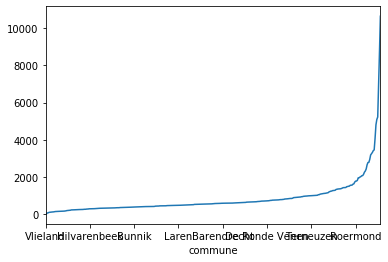

In [55]:
nodes['flow_cent'].sort_values().plot()


In [41]:
edgelist[edgelist.flow.isna()]

,local_1,local_2,flow,lat_start,lon_start,lat_finish,lon_finish,distance,flow_weighted,flow_cent,flow_cent_weighted


In [42]:
G = nx.from_pandas_edgelist(edgelist, source = 'local_1', target = 'local_2', edge_attr = 'flow')

In [43]:
def heaviest(G):
    u, v, w = max(G.edges(data='flow'))
    return (u, v)

In [56]:
comm_detector = nx.community.girvan_newman(G)

In [45]:
u, v, w = max(G.edges(data='flow_cent'))

In [46]:
u, v, w

('Zwolle', 'Zwijndrecht', None)

In [57]:
k = 10

In [58]:
for communities in itertools.islice(comm_detector, k):
    d = tuple(sorted(c) for c in communities)
    break

In [59]:
len(d)

2

In [40]:
d[10]


['Texel']